# Milestone 1: Project Proposal and Data Selection/Preparation

**Step 1: Preparing for Your Proposal**

1. Which client/dataset did you select and why?
   
    *I have chosen 'Client 3: SportsStats' with the Olympics Dataset for 120 years of data. The fact that I have chosen this client is that I spend a lot of my free time practicing sports, and I would like to get interesting insights from the dataset. in addition, the .csv files are not large and can be easily handled.*

2. Describe the steps you took to import and clean the data.
   
    *First, the data was downloaded and stored locally since the volume of files is not big, and does not require Databricks or several clusters to work with. I have used my own customized VSCode text editor for coding and querying since I am used to it. I have also used Excel to check the integrity of the data and both datasets appear to be OK.*

    *Second, I have used pandas from Python to read the .csv files, and the built-in to_sql() function to store the data in a MySQL dataset.*

    *Third, I checked the amount of NaN or NULL values to know how to deal with them, and remove them or not.*


3. Perform an initial exploration of data and provide some screenshots or display some stats of the data you are looking at.
   
   *This preliminary or initial EDA has been carried out with Pandas and Pandas SQL libraries to query the data. Other libraries like seaborn and numpy has been used to help the EDA.*

   *I have performed a quick EDA with simple queries. The athlete_events.csv contains 271116 entries. Some columns can be dropped, since are not relevant to this analysis, for example, the 'Team' column contains some character in the string that should be removed (e.g.: Poland-1). This is more tedious than just using the 'NOC' since it gives us the same information. Additionally, the 'Games' column is not going to be used, and we have this same information with columns 'Year' and 'Season'. Dropping these columns will not reduce the volume of data significantly like notice a speed-up in queries but would keep the data frame cleaner and simpler.*
   
   *An initial EDA with basic queries shows that there are 271116 entries or Event_ID, while there are entries that are fully completed (Sex, years, season...) and do not contain missing values, there are some others like Age, Height, and Weight, that show missing values.*


4. Create an ERD or proposed ERD to show the relationships of the data you are exploring.

    *The ERD shown below was intended for a small relational database, splitting them into two tables, the athletes and the event. Some modifications have been needed, for example, the column 'ID' had no unique values, so it could not be used as a primary key (PK), so a new column "Event_ID" in the 'Event' table has been added as a PK, and as a FK in the 'Atheletes' Table.*



![Image My_ERD](My_ERD.jpg)


**Step 2: Develop a Project Proposal**

**Description**

*The purpose of this project is to get some insight from the data to obtain several statistics based on athletes during different Olympic events in the last 120 years. The audience could be directed to sports enthusiasts and followers, or even coaches/trainers might find them useful. This data might be also relevant for Sports media and curiosity channels of communication.*


**Questions**

- *How relevant is the athletes' age to affect the chance to obtain a medal in the event?*
- *What countries have more chances to get medals, those with more or fewer resources to invest in sports since early years?*
- *How is the Season-countries distribution? Are northern countries more likely to get medals in the Winter Seasons?*
- *Over the years, has the participation of men and women athletes reached equality? the participation of both are more equal in the last decades?*

**Hypothesis**
 
- *Countries at higher latitudes have better performance (medals) in Winter Sports*. 
- *Female and Male participants tend to be equilibrated over the years.*
- *Developed countries have more medals on their records.*
- *It has to be an age of around 25 years, for the best winning medals.*

**Approach**

- *Distribution of age and Medals*
- *Distribution of medals and countries*
- *Distribution of men and women over the years* 

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlite3 import connect

sns.set_theme(style='darkgrid')

Let's read the .csv files

In [58]:
regions = pd.read_csv('SportsStats/noc_regions.csv', sep=',')
events = pd.read_csv('SportsStats/athlete_events.csv', sep=',')

Let's take a look to the regions dataframe.

In [59]:
regions.head()

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [60]:
regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NOC     230 non-null    object
 1   region  227 non-null    object
 2   notes   21 non-null     object
dtypes: object(3)
memory usage: 5.5+ KB


Let's take a look to the events dataframe

In [61]:
events.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [62]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [63]:
events['Sport'].value_counts()

Athletics        38624
Gymnastics       26707
Swimming         23195
Shooting         11448
Cycling          10859
                 ...  
Racquets            12
Jeu De Paume        11
Roque                4
Basque Pelota        2
Aeronautics          1
Name: Sport, Length: 66, dtype: int64

Let's drop some columns and generate SQL tables, and add an 'Event_ID' column to them to work as a PK on the Event Table and as FK in the Athletes Table. (However, since the table is small, we will not need to make any join or especial manipulation.)

In [64]:
Athletes = events.drop(['Team','Games'], axis=1,inplace=False)
Athletes.insert(loc=1, column="Event_ID", value=range(1, 1 + len(Athletes)), allow_duplicates=False)
Event = events.drop(['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games', 'Medal'], axis=1,inplace=False)
Event.insert(loc=1, column="Event_ID", value=range(1, 1 + len(Event)), allow_duplicates=False)

In [65]:
# With this python library we need to create a connector to keep the SQL Tables
engine = connect(':memory:')

In [66]:
Athletes.to_sql('AthletesTable', con=engine)
Event.to_sql('EventTable', con=engine)

271116

Let's find some quick statistics in the from the Tables making use of SQL. For example the ratio of male-female Athletes.

In [67]:
pd.read_sql('''
SELECT 
    sex,
    COUNT(*)                              AS  count,    
    COUNT(*)*100.0/SUM(COUNT(*)) OVER ( ) AS 'percentage (%)'
FROM 
    AthletesTable
GROUP BY 
    sex
''', con=engine)

,Sex,count,percentage (%)
0,F,74522,27.487127
1,M,196594,72.512873


Or the average age, height and weight, per sport in the Games.

In [68]:
pd.read_sql('''
SELECT 
    sport,
    AVG(age)    AS '<age>',
    AVG(height) AS '<height>',
    AVG(weight) AS '<weight>'
FROM 
    AthletesTable
GROUP BY 
    sport
''',con=engine)

,Sport,<age>,<height>,<weight>
0,Aeronautics,26.000000,NaN,NaN
1,Alpine Skiing,23.205462,173.489052,72.068110
2,Alpinism,38.812500,NaN,NaN
3,Archery,27.935226,173.203085,70.011135
4,Art Competitions,45.901009,174.644068,75.290909
...,...,...,...,...
61,Tug-Of-War,29.309524,182.480000,95.615385
62,Volleyball,25.183800,186.994822,78.900214
63,Water Polo,25.659627,184.834648,84.566446
64,Weightlifting,25.502010,167.824801,78.726663


We can check also the percentage of NULL values in the Age, Height and Weight columns

In [69]:
pd.read_sql('''
SELECT 
    COUNT(*) AS total_entries,
    (COUNT(*)-COUNT(age))*100/COUNT(*)          AS NULL_age,
    (COUNT(*)-COUNT(height))*100/COUNT(*)       AS NULL_height,
    (COUNT(*)-COUNT(weight))*100/COUNT(*)       AS NULL_weight
FROM 
    AthletesTable
''', con=engine)

,total_entries,NULL_age,NULL_height,NULL_weight
0,271116,3,22,23


______________________________________________________________________________________


# Milestone 2: Descriptive Stats

**1. Provide a summary of the different descriptive statistics you looked at and WHY.**
 
   *To achieve the business objectives I would try to answer each of the hypotheses questions presented in the Milestone 1. Even if the hypotheses are not true, it does not matter, since it would help to get some insights from the data.*

- *Countries at higher latitudes have better performance (medals) in Winter Sports*.

   As we can see the TOP-20 countries with more amount of medals are those with typically have long and hard strong winters, making sense that are most used to winter sports, or invest more money in this kind of sports.

- *Female and Male participants tend to be equilibrated over the years.*

   The plot shows larger male participation in the Olympic Games vs female participation up to approximately 1990. In the last 3 decades, the participation of both genres has followed the same trend, being slightly larger for men than women. However, it looks like this trend would converge for equality in the next years or soon decade.

- *Developed countries have more medals on their records.*

   The TOP-30 countries with more medals in their records are somehow related to a larger GDP, or at least they are not countries with the lowest GDP. It is noticeable, that even if there are countries whose GDPs are not maybe the best, these countries have a strong a solid culture on sports (e.g.: URSS ex-countries or east-Europe.)

- *It has to be an age of around 25 years, for the best winning medals.*

   It can be seen that for both genres, the average age for winning more medals in the Olympics is at the age of 25+/-5 years.


Let's find out the Top 20 Winter Games medallists.

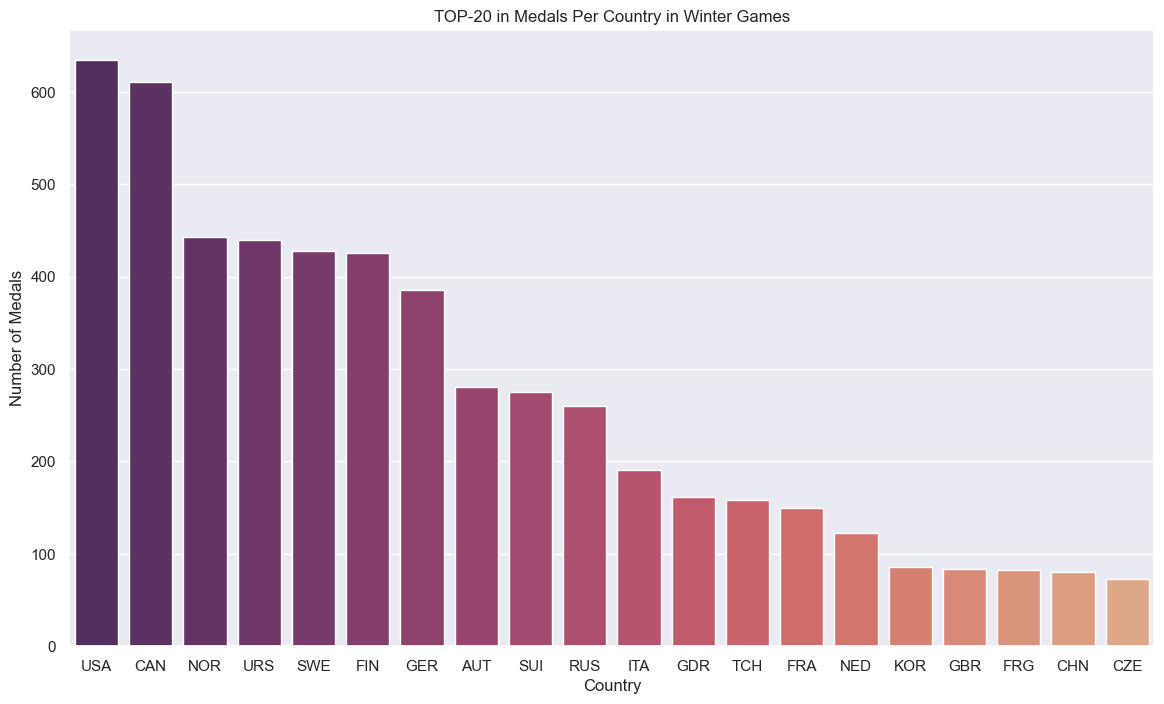

In [70]:
medal_winter = pd.read_sql('''
SELECT
    NOC,
    medal_count
FROM (
    SELECT
        NOC,
        COUNT(*) AS total_count,
        SUM(CASE WHEN medal IS NOT NULL 
                 THEN 1 ELSE 0
                 END) AS medal_count
    FROM
        AthletesTable
    WHERE
        season = 'Winter'
    GROUP BY
        NOC
    ) AS medals
WHERE NOC IS NOT NULL
ORDER BY medal_count DESC
LIMIT 20
''', con=engine)

plt.figure(figsize=[14,8])
sns.color_palette("rocket")
sns.barplot(x=medal_winter['NOC'], y = medal_winter['medal_count'], palette="flare_r")
plt.xlabel('Country')
plt.ylabel('Number of Medals')
plt.title('TOP-20 in Medals Per Country in Winter Games')
plt.show()

Or maybe let's find out the optimal age for winning a medal for both men and women.

In [71]:
medal_age = pd.read_sql('''
SELECT
    age,
    sex,
    medal_count,
    CAST(medal_count AS float)*100 / 271116 AS ratio
FROM (
    SELECT
        age,
        sex,
        COUNT(*) AS total_count,
        SUM(CASE
              WHEN medal IS NOT NULL THEN 1 ELSE 0
            END) AS medal_count
    FROM
        AthletesTable
    GROUP BY
        age
    ) AS medals
WHERE age IS NOT NULL
''', con=engine)

medal_age

,age,sex,medal_count,ratio
0,10.0,M,1,0.000369
1,11.0,F,1,0.000369
2,12.0,F,6,0.002213
3,13.0,F,16,0.005902
4,14.0,F,75,0.027663
...,...,...,...,...
69,81.0,M,0,0.000000
70,84.0,M,0,0.000000
71,88.0,M,0,0.000000
72,96.0,M,0,0.000000


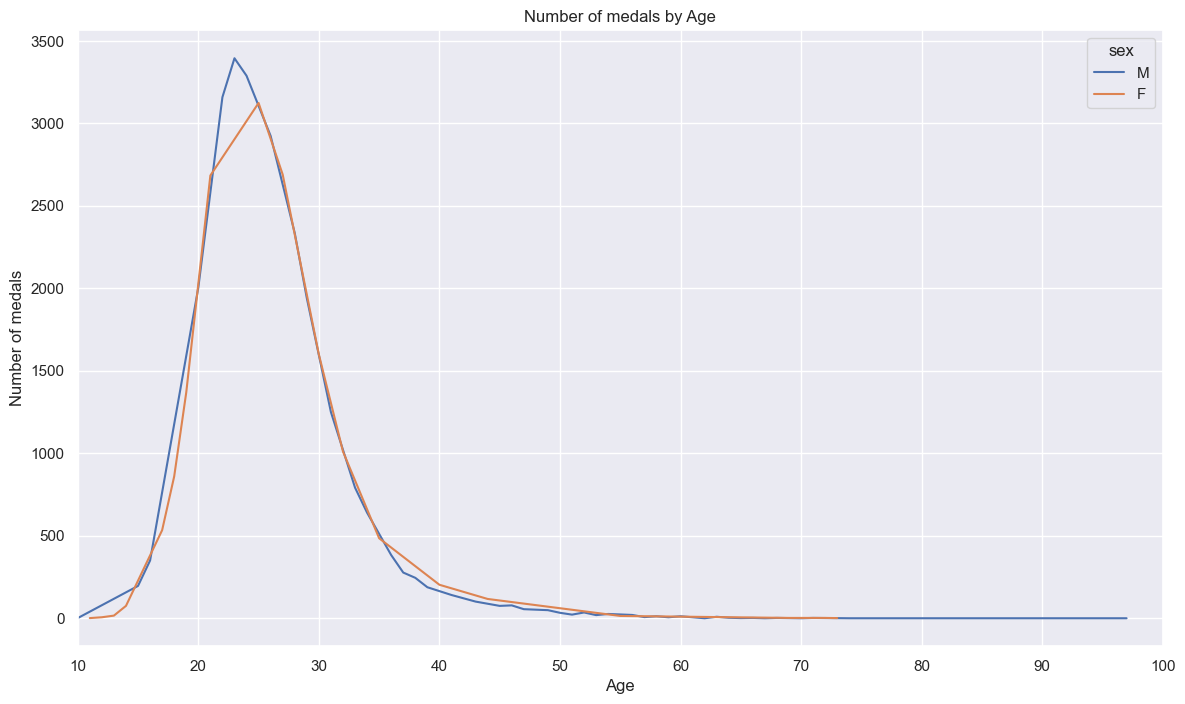

In [72]:

plt.figure(figsize=[14,8])

sns.lineplot(x=medal_age['age'], y=medal_age['medal_count'], hue=medal_age['sex'])
plt.xlabel('Age')
plt.ylabel('Number of medals')
plt.xlim(10,100)
plt.title('Number of medals by Age')
plt.show()

We can query the total number of medals won by country in the last 120 years.

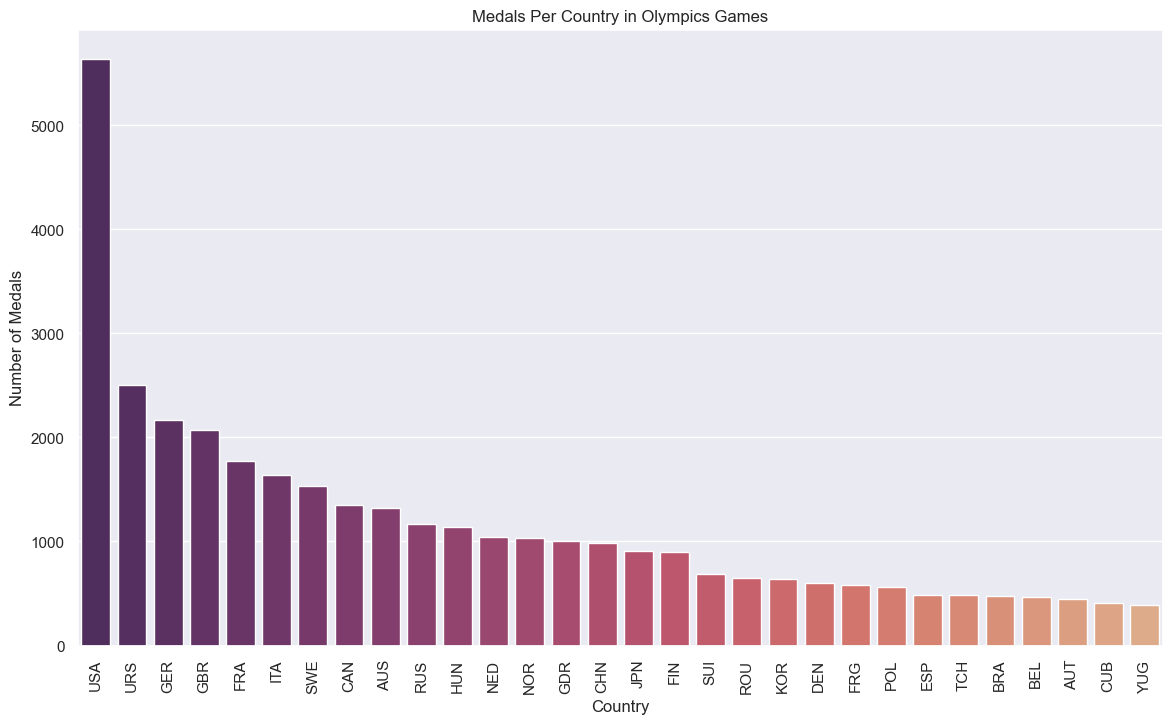

In [73]:
medal_winter = pd.read_sql('''
SELECT
    NOC,
    medal_count
FROM (
    SELECT
        NOC,
        COUNT(*) AS total_count,
        SUM(CASE WHEN medal IS NOT NULL THEN 1 ELSE 0 END) AS medal_count
    FROM
        AthletesTable
    GROUP BY
        NOC
    ) AS medals
WHERE NOC IS NOT NULL
ORDER BY medal_count DESC
LIMIT 30
''', con=engine)

plt.figure(figsize=[14,8])
sns.barplot(x=medal_winter['NOC'], y = medal_winter['medal_count'], palette="flare_r")
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.ylabel('Number of Medals')
plt.title('Medals Per Country in Olympics Games')
plt.show()

We can check the participation of men and women in the Olympic Games.

In [74]:
genre_count = pd.read_sql('''
SELECT
    Year,
    SUM(CASE WHEN sex = 'M' THEN 1 ELSE 0 END) AS male_count,
    SUM(CASE WHEN sex = 'F' THEN 1 ELSE 0 END) AS female_count    
FROM
    AthletesTable
GROUP BY
    Year
''', con=engine)


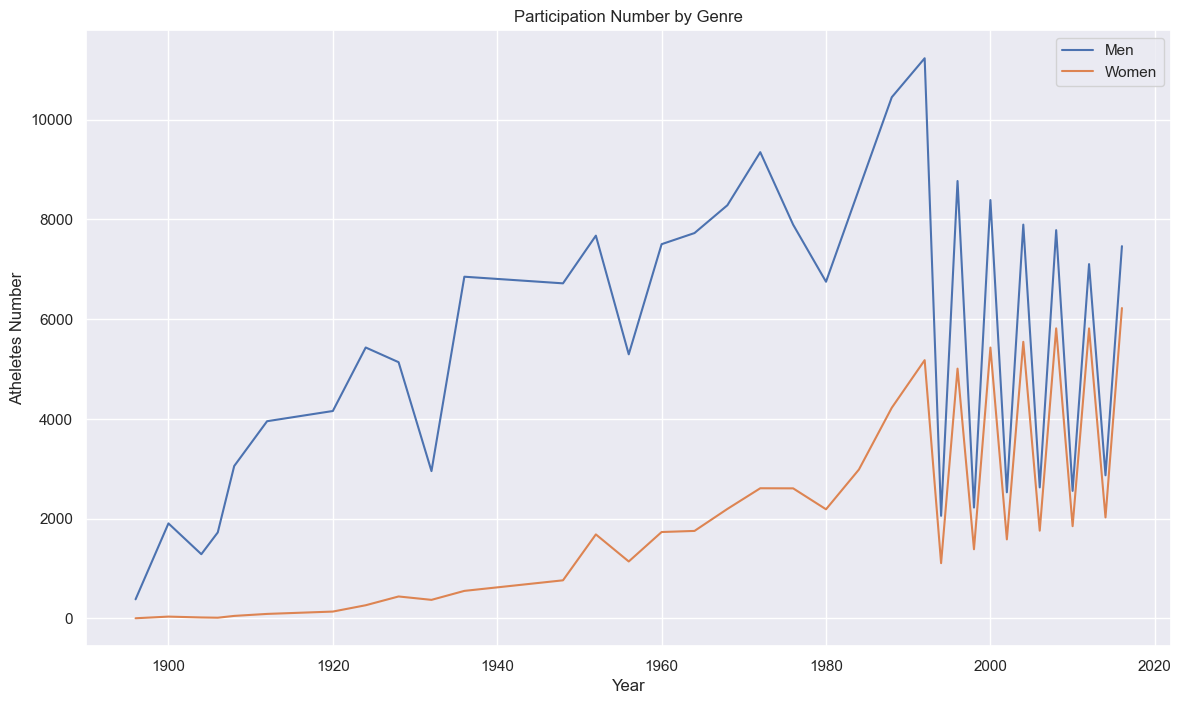

In [75]:
plt.figure(figsize=[14,8])
sns.lineplot(x=genre_count['Year'], y=genre_count['male_count'], label='Men')
sns.lineplot(x=genre_count['Year'], y=genre_count['female_count'], label='Women')
plt.xlabel('Year')
plt.ylabel('Atheletes Number')
plt.title('Participation Number by Genre')
plt.show()




**1. Submit 2-3 key points you may have discovered about the data, e.g. new relationships? Aha's! Did you come up with additional ideas for other things to review?**

   - *There is some drop in men's participation in the Olympics in some years, it could be interesting to find out why.*
   - *Some countries do not exist anymore, or they have a new NOC, these medals should be added if the country has not changed geographically quite a lot.*
   - *In the case of the URSS, the medallist country should be 'changed' to the actual country, but this could carry out some political issues.*

**2. Did you prove or disprove any of your initial hypotheses? If so, which one and what do you plan to do next?**
   
   *I prove that most of the hypotheses established in the beginning were right. However, it should be checked deeper into the data to get better insights. Until now, these results are barely shallow and should be understood as a general trend.*

**3. What additional questions are you seeking to answer?**

   - *Grouping Ex-URSS countries together.*
   - *In the case of USA, race of the winners (e.g: how many Jamaicans run for USA, etc...)*
   - *The distribution of age and Medal type (Gold, Silver, Bronze)*
   - *The ratio between age and year by Medal type (e.g: if the average age of winning Silver is 30 years old, how has this evolved with the years)*
   - *Dropping sports that have appeared in the Olympics just a few times (Roque, Basque Pelota, Areonautics)*

----------------------------

# Milestone 3: Beyond Descriptive Stats 

**Dive Deeper**

*In this Milestone, I would look through correlations between features that initially were missed. For that, Pearson correlation can be useful as well as a heatmap between features.*

*It appears a Person's Correlation of 0.8 between Weight and Height, implying that these two features are quite related, as expected.*

**Go Broader**

*Let's examine which is the average BMI for each sport for the entries that we have enough data. We can see that the sports with the largest BMI are Weightlifting and Athletics, while Rhythmic Gymnastics has the lowest BMI, followed by Triathlon. Surprisingly, Curling is the 3rd sport with the largest BMI, above Ice Hockey or Rugby.*

*We can see also, that the evolution of the medals ratio has tended to be stabilized over the years, most probably a change in the regulations, or tech advances.*

*It exists a strong correlation of about 0.94 between the number of medals won in Summer and Winter Sports.*

**New Metric**

- BMI: indicates a proper or suitable sport for an athlete
- Medal Ratio: Indicative of the distribution of medals

Let's find a quick correlation table of the Pearson coeeficient.

In [76]:
pears = Athletes.corr(method='pearson',numeric_only=True)
pears

,ID,Event_ID,Age,Height,Weight,Year
ID,1.000000,0.999993,-0.003631,-0.011141,-0.009176,0.011885
Event_ID,0.999993,1.000000,-0.003648,-0.011172,-0.009198,0.011944
Age,-0.003631,-0.003648,1.000000,0.138246,0.212069,-0.115137
Height,-0.011141,-0.011172,0.138246,1.000000,0.796213,0.047578
Weight,-0.009176,-0.009198,0.212069,0.796213,1.000000,0.019095
Year,0.011885,0.011944,-0.115137,0.047578,0.019095,1.000000


Transform it into a SQL Table

In [77]:
pears.to_sql('PearsonTable', con=engine, if_exists='replace')

6

And vizualizate a heatmap for an easier intuition.

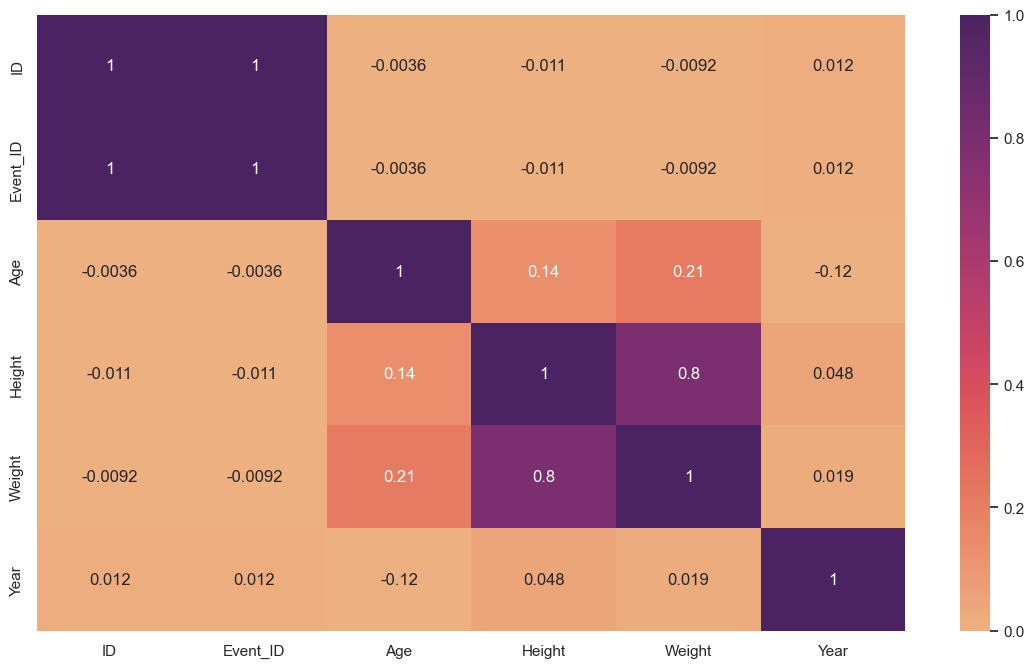

In [78]:
plt.figure(figsize=[14,8])
sns.heatmap(pears, vmin=0, vmax=1, cmap='flare', cbar=True, annot=True)
plt.show()

We can see a high correlation between the weight and height, that we can use for the BMI. So, lets make a BMI Table

In [79]:
BMI = pd.read_sql('''
SELECT
    Year,
    Age,
    Sex,
    Weight,
    Height,
    Season,
    Sport,
    (Weight)/(Height/100 * Height/100) AS BMI
FROM
    AthletesTable
WHERE
     (Height IS NOT NULL) AND (Weight IS NOT NULL)
GROUP BY
    Sport
ORDER BY
    BMI DESC
''', con=engine)

BMI

,Year,Age,Sex,Weight,Height,Season,Sport,BMI
0,2016,22.0,F,125.0,170.0,Summer,Weightlifting,43.252595
1,2000,31.0,M,130.0,189.0,Summer,Athletics,36.393158
2,2006,24.0,M,95.0,175.0,Winter,Curling,31.020408
3,1924,21.0,M,98.0,178.0,Summer,Rugby,30.930438
4,2000,21.0,M,91.0,179.0,Summer,Baseball,28.401111
5,2002,26.0,M,96.0,186.0,Winter,Ice Hockey,27.748873
6,1992,27.0,M,82.0,172.0,Summer,Canoeing,27.717685
7,1992,20.0,M,85.0,176.0,Winter,Alpine Skiing,27.440599
8,1932,44.0,M,91.0,183.0,Summer,Art Competitions,27.173102
9,1998,24.0,M,98.0,190.0,Winter,Bobsleigh,27.146814


And we can plot the relationship between BMI and the Sport in the Olympics

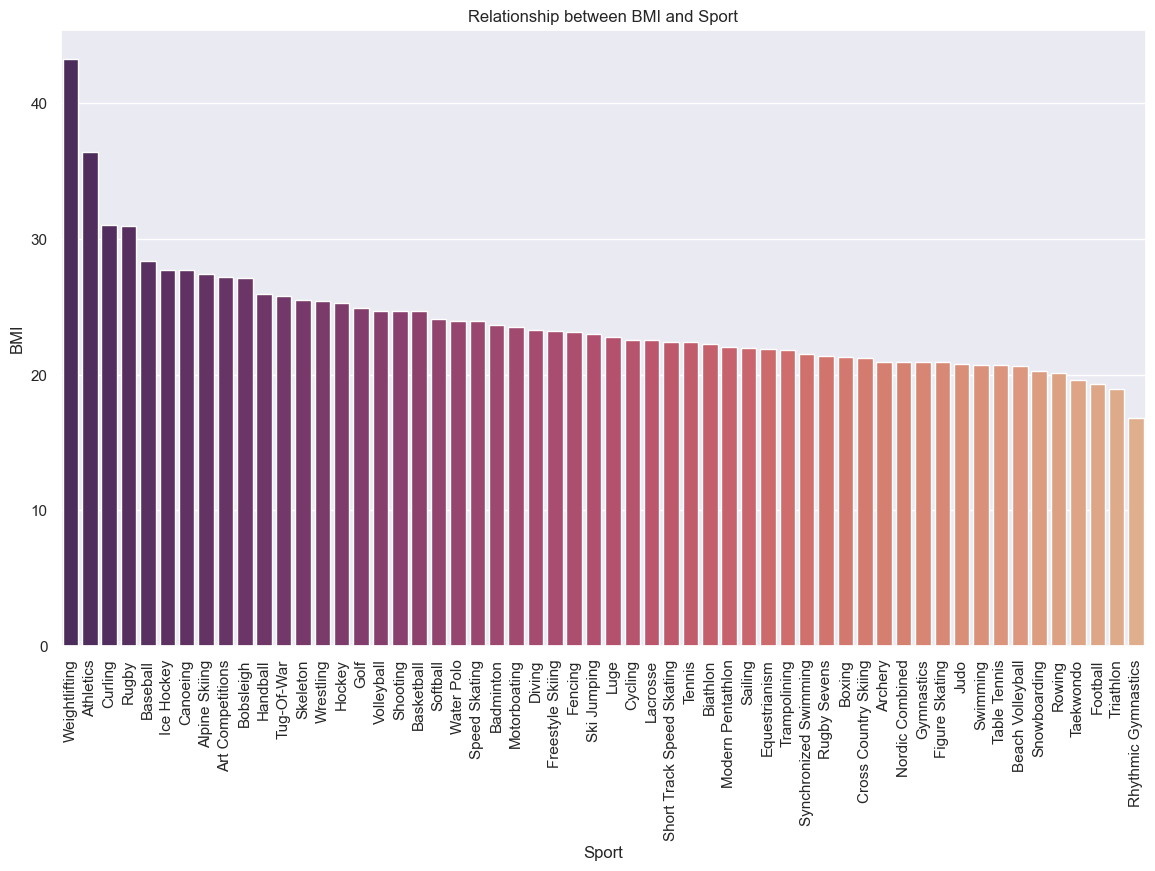

In [80]:
plt.figure(figsize=[14,8])
sns.barplot(x=BMI['Sport'], y=BMI['BMI'], palette="flare_r")
plt.xlabel('Sport')
plt.ylabel('BMI')
plt.title('Relationship between BMI and Sport')
plt.xticks(rotation=90)
plt.show()

We cna generate a SQL table where we can calculate the medal type ratio.

In [81]:
medal_ratio = pd.read_sql('''
SELECT
    sex,
    year,
    season,
    CAST(medal_count AS FLOAT) / total_count AS medal_ratio,
    CAST(gold_count AS FLOAT) / medal_count AS gold_ratio,
    CAST(silver_count AS FLOAT) / medal_count AS silver_ratio,
    CAST(bronze_count AS FLOAT) / medal_count AS bronze_ratio
FROM
(
    SELECT
        sex,
        year,
        season,
        COUNT(*) AS total_count,
        SUM(CASE WHEN Medal IS NOT NULL THEN 1 ELSE 0 END) AS medal_count,
        SUM(CASE WHEN Medal = 'Gold'    THEN 1 ELSE 0 END) AS Gold_count,
        SUM(CASE WHEN Medal = 'Silver'  THEN 1 ELSE 0 END) AS Silver_count,
        SUM(CASE WHEN Medal = 'Bronze'  THEN 1 ELSE 0 END) AS Bronze_count
        FROM
            AthletesTable
        GROUP BY
            year 
    ) AS medalsTable
''', con=engine)

medal_ratio

,sex,year,season,medal_ratio,gold_ratio,silver_ratio,bronze_ratio
0,M,1896,Summer,0.376316,0.433566,0.300699,0.265734
1,M,1900,Summer,0.311983,0.332781,0.377483,0.289735
2,M,1904,Summer,0.373559,0.355967,0.335391,0.308642
3,M,1906,Summer,0.264282,0.342795,0.340611,0.316594
4,M,1908,Summer,0.267978,0.353791,0.338147,0.308063
5,M,1912,Summer,0.232921,0.346440,0.334750,0.318810
6,M,1920,Summer,0.304753,0.376911,0.342508,0.280581
7,M,1924,Summer,0.168979,0.345114,0.331601,0.323285
8,M,1928,Summer,0.147650,0.334143,0.324423,0.341434
9,F,1932,Summer,0.222523,0.353180,0.332882,0.313938


And we can plot it over the years to check the evolution in the "medal regularization" for example.

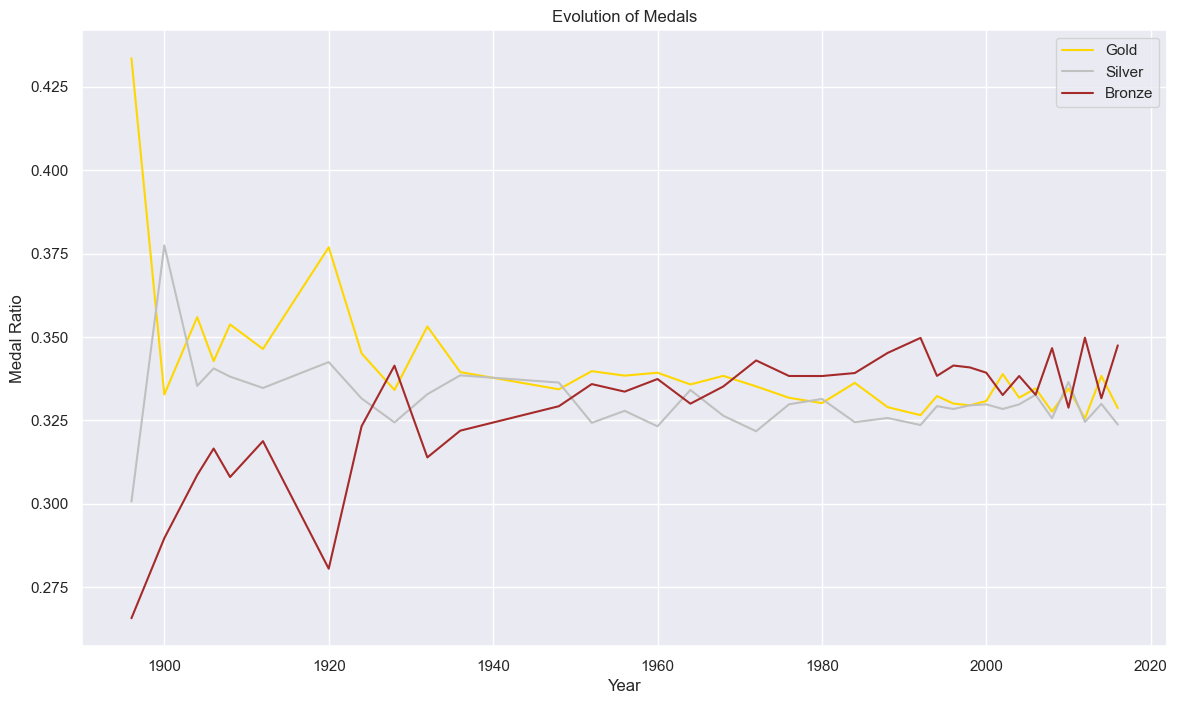

In [82]:
plt.figure(figsize=[14,8])
sns.lineplot(data=medal_ratio, x='year', y = 'gold_ratio',   color='gold', label='Gold')
sns.lineplot(data=medal_ratio, x='year', y = 'silver_ratio', color='silver', label='Silver')
sns.lineplot(data=medal_ratio, x='year', y = 'bronze_ratio', color='brown', label='Bronze')
plt.xlabel('Year')
plt.ylabel('Medal Ratio')
plt.title('Evolution of Medals')
plt.show()

We can split it into Winter Sports

In [83]:
winter_ratio = pd.read_sql('''
SELECT
    sex,
    year,
    total_count,
    CAST(medal_count AS FLOAT) / total_count AS medal_ratio,
    CAST(gold_count AS FLOAT) / medal_count AS gold_ratio,
    CAST(silver_count AS FLOAT) / medal_count AS silver_ratio,
    CAST(bronze_count AS FLOAT) / medal_count AS bronze_ratio
FROM
(
    SELECT
        sex,
        year,
        COUNT(*) AS total_count,
        SUM(CASE WHEN Medal IS NOT NULL THEN 1 ELSE 0 END) AS medal_count,
        SUM(CASE WHEN Medal = 'Gold'    THEN 1 ELSE 0 END) AS Gold_count,
        SUM(CASE WHEN Medal = 'Silver'  THEN 1 ELSE 0 END) AS Silver_count,
        SUM(CASE WHEN Medal = 'Bronze'  THEN 1 ELSE 0 END) AS Bronze_count
        FROM
            AthletesTable
        WHERE
            Season = 'Winter'
        GROUP BY
            year 
    ) AS medalsTable
''', con=engine)

winter_ratio

,sex,year,total_count,medal_ratio,gold_ratio,silver_ratio,bronze_ratio
0,M,1924,460,0.282609,0.423077,0.292308,0.284615
1,M,1928,582,0.152921,0.337079,0.314607,0.348315
2,M,1932,352,0.261364,0.347826,0.347826,0.304348
3,M,1936,895,0.120670,0.333333,0.342593,0.324074
4,M,1948,1075,0.125581,0.303704,0.355556,0.340741
5,M,1952,1088,0.125000,0.330882,0.323529,0.345588
6,M,1956,1307,0.114767,0.340000,0.326667,0.333333
7,M,1960,1116,0.131720,0.340136,0.326531,0.333333
8,M,1964,1778,0.104612,0.327957,0.360215,0.311828
9,M,1968,1891,0.105235,0.331658,0.351759,0.316583


... and Summer Sports.

In [84]:
summer_ratio = pd.read_sql('''
SELECT
    sex,
    year,
    total_count,
    CAST(medal_count AS FLOAT) / total_count AS medal_ratio,
    CAST(gold_count AS FLOAT) / medal_count AS gold_ratio,
    CAST(silver_count AS FLOAT) / medal_count AS silver_ratio,
    CAST(bronze_count AS FLOAT) / medal_count AS bronze_ratio
FROM
(
    SELECT
        sex,
        year,
        COUNT(*) AS total_count,
        SUM(CASE WHEN Medal IS NOT NULL THEN 1 ELSE 0 END) AS medal_count,
        SUM(CASE WHEN Medal = 'Gold'    THEN 1 ELSE 0 END) AS Gold_count,
        SUM(CASE WHEN Medal = 'Silver'  THEN 1 ELSE 0 END) AS Silver_count,
        SUM(CASE WHEN Medal = 'Bronze'  THEN 1 ELSE 0 END) AS Bronze_count
        FROM
            AthletesTable
        WHERE
            season = 'Summer'
        AND 
            year >= 1924
        GROUP BY
            year 
    ) AS medalsTable
''', con=engine)

summer_ratio

,sex,year,total_count,medal_ratio,gold_ratio,silver_ratio,bronze_ratio
0,M,1924,5233,0.158991,0.332933,0.337740,0.329327
1,M,1928,4992,0.147035,0.333787,0.325613,0.340599
2,F,1932,2969,0.217918,0.353941,0.330757,0.315301
3,M,1936,6506,0.140947,0.340240,0.338059,0.321701
4,M,1948,6405,0.133021,0.339202,0.333333,0.327465
5,M,1952,8270,0.108464,0.341137,0.324415,0.334448
6,M,1956,5127,0.174176,0.338186,0.328108,0.333707
7,M,1960,8119,0.112206,0.339188,0.322722,0.338090
8,M,1964,7702,0.133602,0.337221,0.329446,0.333333
9,M,1968,8588,0.123079,0.339640,0.321665,0.338694


And we can see if there is a correlation between those that are good at winning medals in Summer Sports are also in Winter Sports.

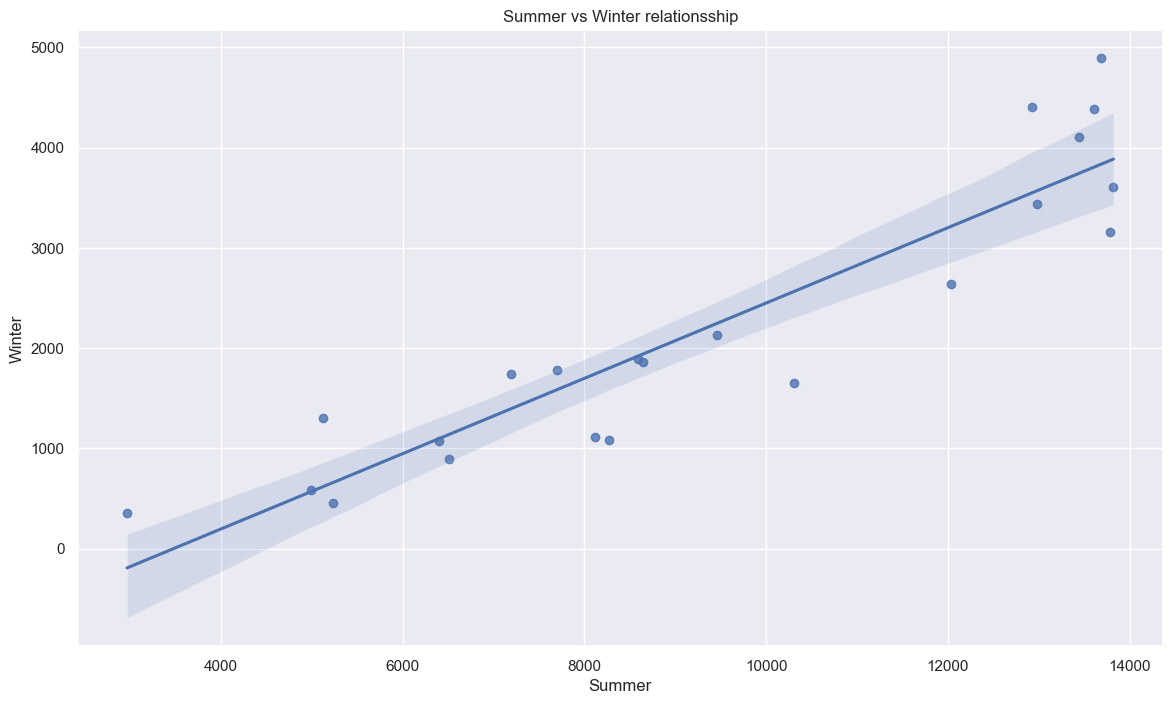

In [85]:
plt.figure(figsize=[14,8])
sns.regplot(x=summer_ratio['total_count'], y=winter_ratio['total_count'],fit_reg=True)
plt.xlabel('Summer')
plt.ylabel('Winter')
plt.title('Summer vs Winter relationsship')
plt.show()

In [86]:
correlation_coeffs=np.corrcoef(x=summer_ratio['total_count'], y=winter_ratio['total_count'])
correlation_coeffs

array([[1.        , 0.92414254],
       [0.92414254, 1.        ]])